In [1]:
import scanpy as sc
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from datetime import datetime

# Import from the trajDTW package instead of individual modules
from trajDTW import (
    anndata_to_3d_matrix, 
    calculate_trajectory_attributes,
    plot_trajectory_dotplot,
    calculate_trajectory_conservation,
    TrajectoryFitter,
    get_most_conserved_samples,
    fit_with_conserved_samples
)

# Set output directory
output_dir = Path("/home/gilberthan/Desktop/disk2/202409_tooth/process/trajectory/20250414_epi_run/")
output_dir.mkdir(parents=True, exist_ok=True)

print("\n=== Trajectory Conservation Analysis Pipeline ===\n")
print(f"Results will be saved to: {output_dir}")

# ================ 1. BUILD 3D MATRIX ================
print("\n1. Building 3D Matrix from AnnData")
print("-" * 50)

# Load AnnData
print("Loading AnnData...")
adata = sc.read_h5ad("../../../processed_data/toy_data/20250412_example_trajconserve.h5ad")
print(f"AnnData shape: {adata.shape}")

/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (



=== Trajectory Conservation Analysis Pipeline ===

Results will be saved to: /home/gilberthan/Desktop/disk2/202409_tooth/process/trajectory/20250414_epi_run

1. Building 3D Matrix from AnnData
--------------------------------------------------
Loading AnnData...
AnnData shape: (8000, 100)


In [2]:

# Convert to 3D matrix
print("\nConverting to 3D matrix using Gaussian kernel interpolation...")
result = anndata_to_3d_matrix(
    adata=adata,
    pseudo_col='pseudo',     # Column containing pseudotime
    batch_col='Sample',      # Column containing batch information
    n_bins=100,              # Number of interpolation points
    adaptive_kernel=True,    # Use adaptive kernel width
    gene_thred=0.1,          # Filter genes expressed in at least 10% of bins
    batch_thred=0.3,         # Filter batches covering at least 30% of timeline
    ensure_tail=True         # Ensure batches cover the tail region
)
reshaped_data = result["reshaped_data"]



Converting to 3D matrix using Gaussian kernel interpolation...
Calculating bin means in parallel...


[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.


[Parallel(n_jobs=36)]: Done 184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=36)]: Done 692 out of 692 | elapsed:    3.3s finished
[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.


Filtered to 82 genes that meet expression threshold
Batches after coverage filtering: ['CAGE_Chiba_Epi', 'Epi_Chiba', 'MolarE145_Outie', 'Runx2_Shuo', 'ToothNc_Junjun_P3.5', 'ToothNc_Junjun_P7.5', 'ToothNiche_Hong_PN7']
Contingency table of unique bins in tail region:
Batch CAGE_Chiba_Epi filtered out: 0 tail bins <= 2.0 threshold
Batch Epi_Chiba qualified: 4 tail bins > 2.0 threshold
Batch MolarE145_Outie filtered out: 0 tail bins <= 2.0 threshold
Batch Runx2_Shuo qualified: 10 tail bins > 2.0 threshold
Batch ToothNc_Junjun_P3.5 qualified: 9 tail bins > 2.0 threshold
Batch ToothNc_Junjun_P7.5 filtered out: 0 tail bins <= 2.0 threshold
Batch ToothNiche_Hong_PN7 qualified: 27 tail bins > 2.0 threshold
Final qualified batches: ['Epi_Chiba', 'Runx2_Shuo', 'ToothNc_Junjun_P3.5', 'ToothNiche_Hong_PN7']
Computing Gaussian kernel weights...
Interpolating gene expression for 4 batches and 82 genes using 36 parallel jobs...


/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/home/gilberthan/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning:

Interpolation complete. 3D matrix shape: (4, 100, 82)


[Parallel(n_jobs=36)]: Done 328 out of 328 | elapsed:    4.1s finished


In [3]:
result.keys()

dict_keys(['reshaped_data', 'binned_means', 'filtered_genes', 'batch_names', 'metadata'])

In [4]:
attributes = calculate_trajectory_attributes(result["reshaped_data"], result["filtered_genes"], result["batch_names"])

/home/gilberthan/Desktop/disk2/202409_tooth/trajDTW/trajDTW/trajDTW/trajectory_attributes.py:243: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  peak_df = peak_df.applymap(lambda x: 'Early' if x <= num_bins/3 else


In [5]:
dottable = attributes.to_dot_table()

[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.


shape of reshaped_data:  (4, 100, 82)
Start calculating trajectory conservation...
Calculating pairwise DTW distances for 82 genes across 4 samples (6 pairwise comparisons per gene)...
Using normalization method: zscore
Filtering samples by variation: threshold=1, metric=max
Processing 82 genes using 36 parallel jobs...


[Parallel(n_jobs=36)]: Done  82 out of  82 | elapsed:    0.2s finished


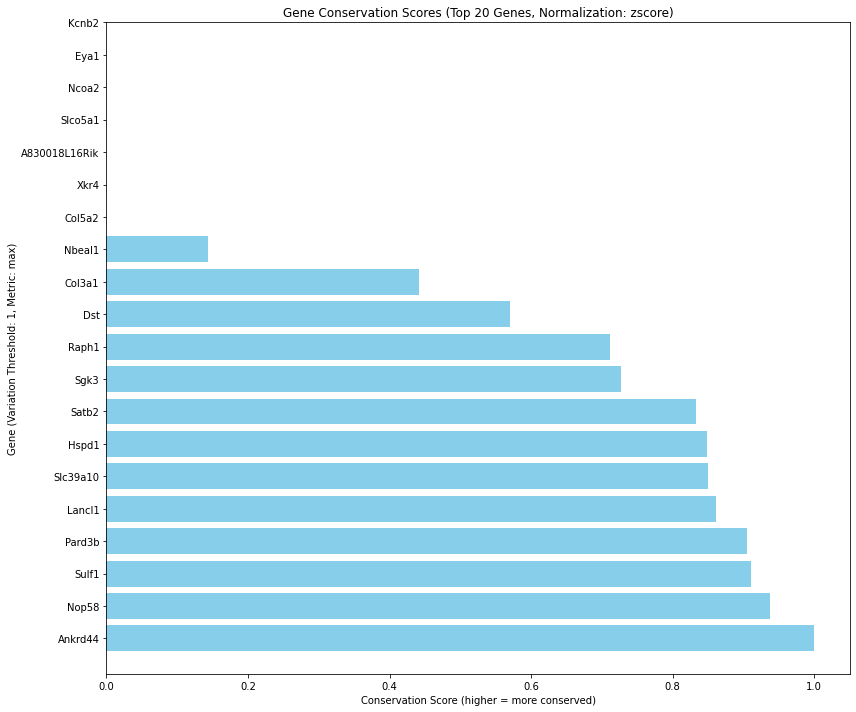

In [6]:

# Define sample variation filtering parameters
VARIATION_FILTERING = {
    'off': {
        'filter_samples_by_variation': False
    },
    'basic': {
        'filter_samples_by_variation': True,
        'variation_threshold': 1,  # Minimum coefficient of variation
        'variation_metric': 'max',
        'min_valid_samples': 2       # At least 2 samples needed
    },
    'stringent': {
        'filter_samples_by_variation': True,
        'variation_threshold': 0.2, 
        'variation_metric': 'max',
        'min_valid_samples': 2
    }
}

# Choose filtering level
variation_filter_level = 'basic'  # Options: 'off', 'basic', 'stringent'
filter_params = VARIATION_FILTERING[variation_filter_level]
filtered_genes = result['filtered_genes']
print("shape of reshaped_data: ", reshaped_data.shape)
print("Start calculating trajectory conservation...")
conservation_results = calculate_trajectory_conservation(
    trajectory_data=reshaped_data,
    gene_names=filtered_genes, 
    save_dir=output_dir,
    prefix="traj_conservation",
    dtw_radius=3,            # Radius parameter for fastdtw
    use_fastdtw=True,
    normalize='zscore',      # Normalize trajectories before DTW calculation
    **filter_params          # Apply sample variation filtering
)

In [7]:
gene_conservation = conservation_results["conservation_scores"]["gene"].head()




/home/gilberthan/Desktop/disk2/202409_tooth/trajDTW/trajDTW/trajDTW/trajectory_attributes.py:243: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  peak_df = peak_df.applymap(lambda x: 'Early' if x <= num_bins/3 else


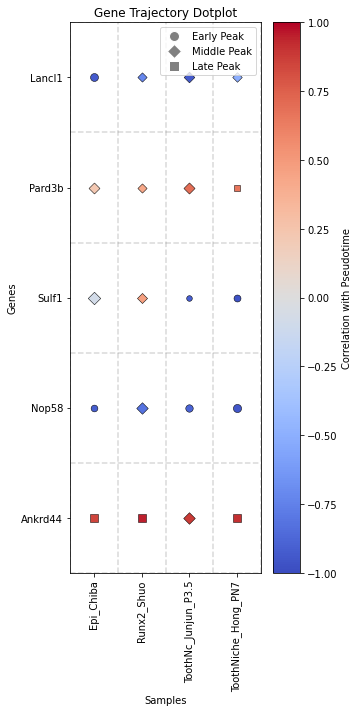

In [10]:
attributes = calculate_trajectory_attributes(result["reshaped_data"], result["filtered_genes"], result["batch_names"])
dottable = attributes.to_dot_table(genes = gene_conservation)
fig = plot_trajectory_dotplot(dottable,dot_scale=100,col_spacing = 0.5)

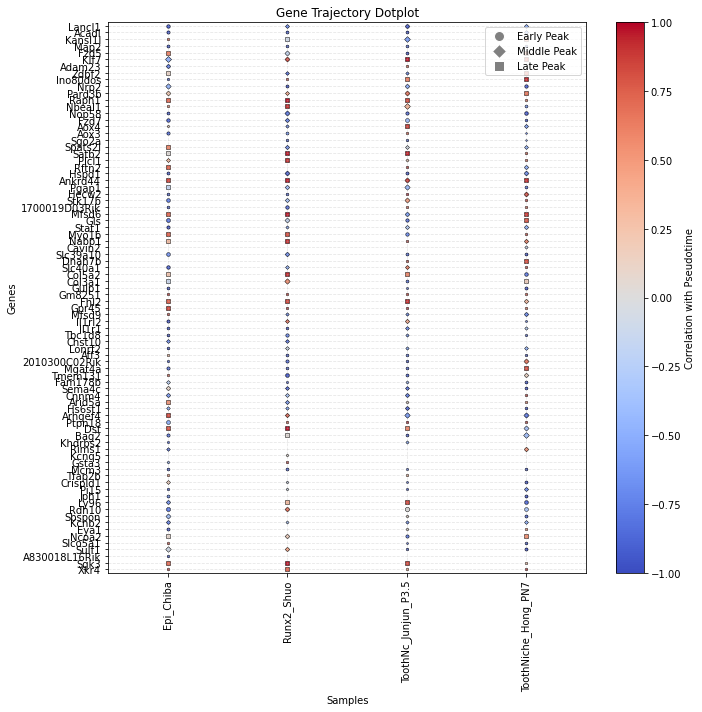

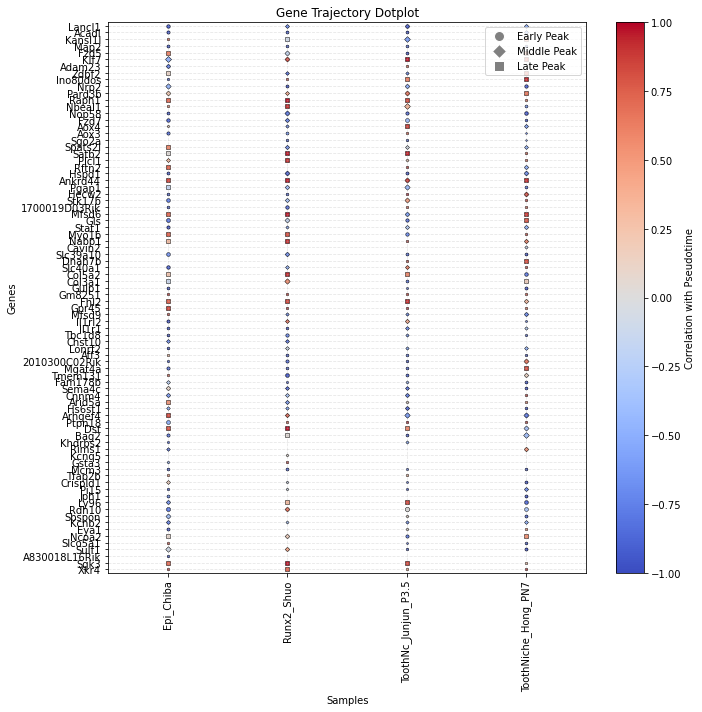

In [ ]:
plot_trajectory_dotplot(dottable,dot_scale=20)

    



